**Business Undertanding**

**Data Understanding**

In [35]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

In [24]:
data = pd.read_csv('data/kc_house_data.csv')

**Data Preparation**: Data Cleaning

Previewing the data I can see there are some null values I'll have to deal with. These are coming from year renovated, view, and waterfront. It also looks like sqft_basement is an object not at integer. On a closer look, many of the rows contain a '?'. I'm going to fill nulls and examine the data more closely. 

For Waterfront and View: 
 - There are only 146 houses that are coded as waterfront. I am going to fill the null values to 0 since it won't affect the distribution much 
 - The view column has 63 null values. This column describes how many times a house has been viewed (not the views from the house), which I don't see as being really important as a feature because there are a lot of reasons it could/could not have been viewed a given number of times. I am going to fill these nulls with a 0 assuming they were not available to view.

In [25]:
data['waterfront'].fillna(0.0, inplace=True)
data['view'].fillna(0.0, inplace=True)

For year renovated, I am going to assume the nulls represent houses that were not renovated. I'm going to fill the nulls with 0, but also make a binary indicator column that just tells me whether the house was or was not renovated instead of what year. I'll keep both columns for now.

In [26]:
data['yr_renovated'].fillna(0.0, inplace=True)

#new column  
data['is_renovated'] = 0

# loop through the data and input a 1 where the house was renovated
for row in data.index:
    if data['yr_renovated'][row] != 0.0:
        data['is_renovated'][row] = 1

C:\Users\christina.sarver\Anaconda3\envs\learn-env\lib\site-packages\ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':


Lastly for squarefoot basement, I am going to replace all the '?' symbols with 0 to make this column readable, assuming these houses do not have basements.

In [27]:
data['sqft_basement'] = data['sqft_basement'].map(lambda x: x.replace("?", "0"))
data['sqft_basement'] = pd.to_numeric(data['sqft_basement'], downcast='integer')

In [28]:
# data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21597 entries, 0 to 21596
Data columns (total 22 columns):
id               21597 non-null int64
date             21597 non-null object
price            21597 non-null float64
bedrooms         21597 non-null int64
bathrooms        21597 non-null float64
sqft_living      21597 non-null int64
sqft_lot         21597 non-null int64
floors           21597 non-null float64
waterfront       21597 non-null float64
view             21597 non-null float64
condition        21597 non-null int64
grade            21597 non-null int64
sqft_above       21597 non-null int64
sqft_basement    21597 non-null int16
yr_built         21597 non-null int64
yr_renovated     21597 non-null float64
zipcode          21597 non-null int64
lat              21597 non-null float64
long             21597 non-null float64
sqft_living15    21597 non-null int64
sqft_lot15       21597 non-null int64
is_renovated     21597 non-null int64
dtypes: float64(8), int16(1), int64(12

After running a .describe and examining some columns, I see one outlier I want to remove because it looks incorrect - a house that has 33 bedrooms and 1.75 bath that cost only $640k.

In [29]:
data.drop(data.index[15856], inplace=True)

***Data Preparation***: Checking for multicollinearity, normalizing, scaling, encoding categorical data

First I'm going to separate my continuous from categorical columns. I am excluding ID, date and the sqft 15 columns for now. The dates are all from the same 2 years so there isn't a diverse amount of data and the neighboring house info is not relevant now but I could bring it in later.

In [34]:
cat_cols= ['bedrooms', 'bathrooms', 'floors', 'waterfront', 'condition', 'grade', 'yr_built', 'view', 'is_renovated', 'zipcode']
con_cols = ['sqft_living', 'sqft_lot', 'sqft_above', 'sqft_basement','lat', 'long']
y = data['price']

Then I'm going to run a few visual techniques to take a look at my data and decide where I can clean it up for modeling. 

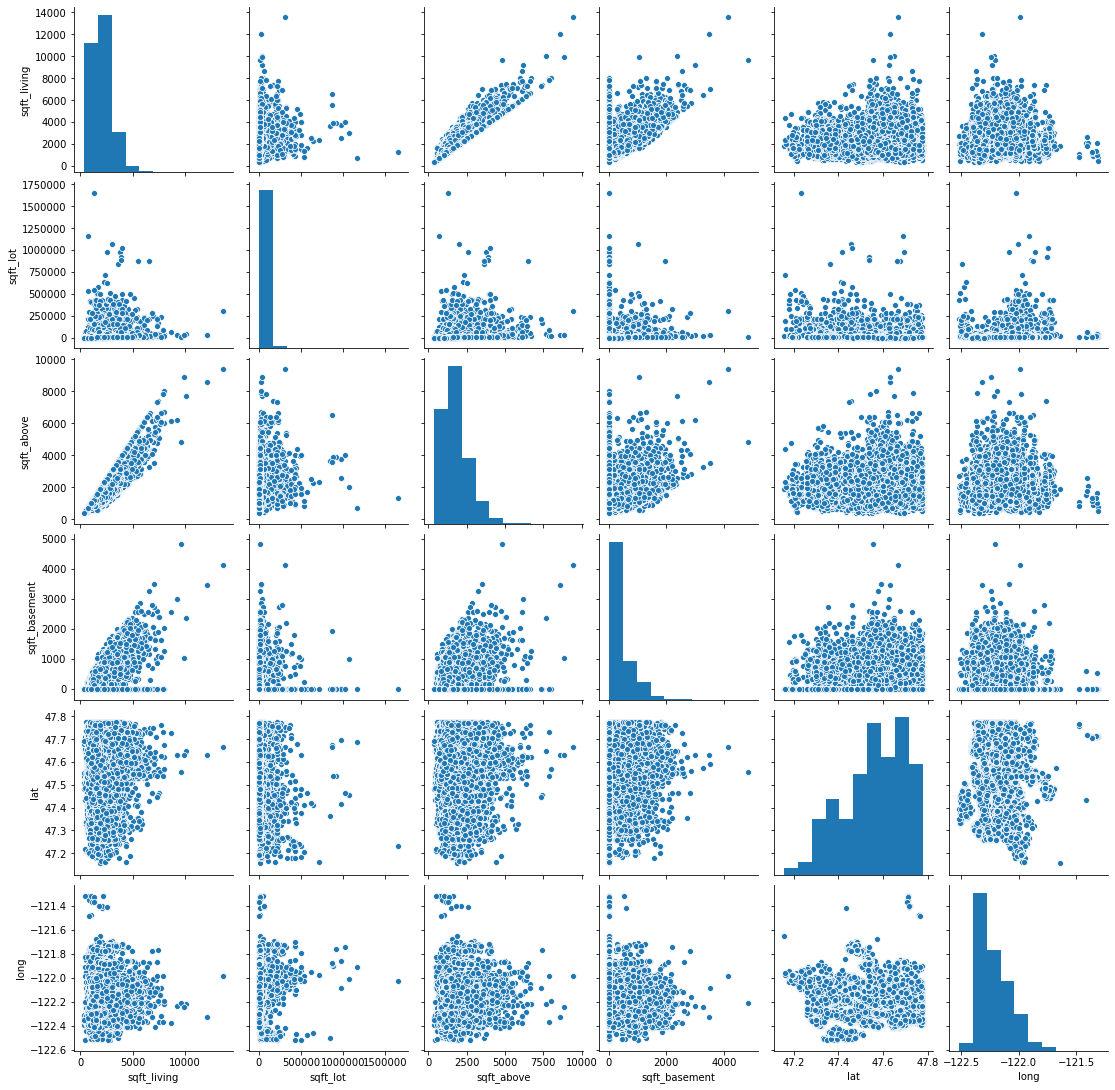

In [9]:
sns.pairplot(data[con_cols])

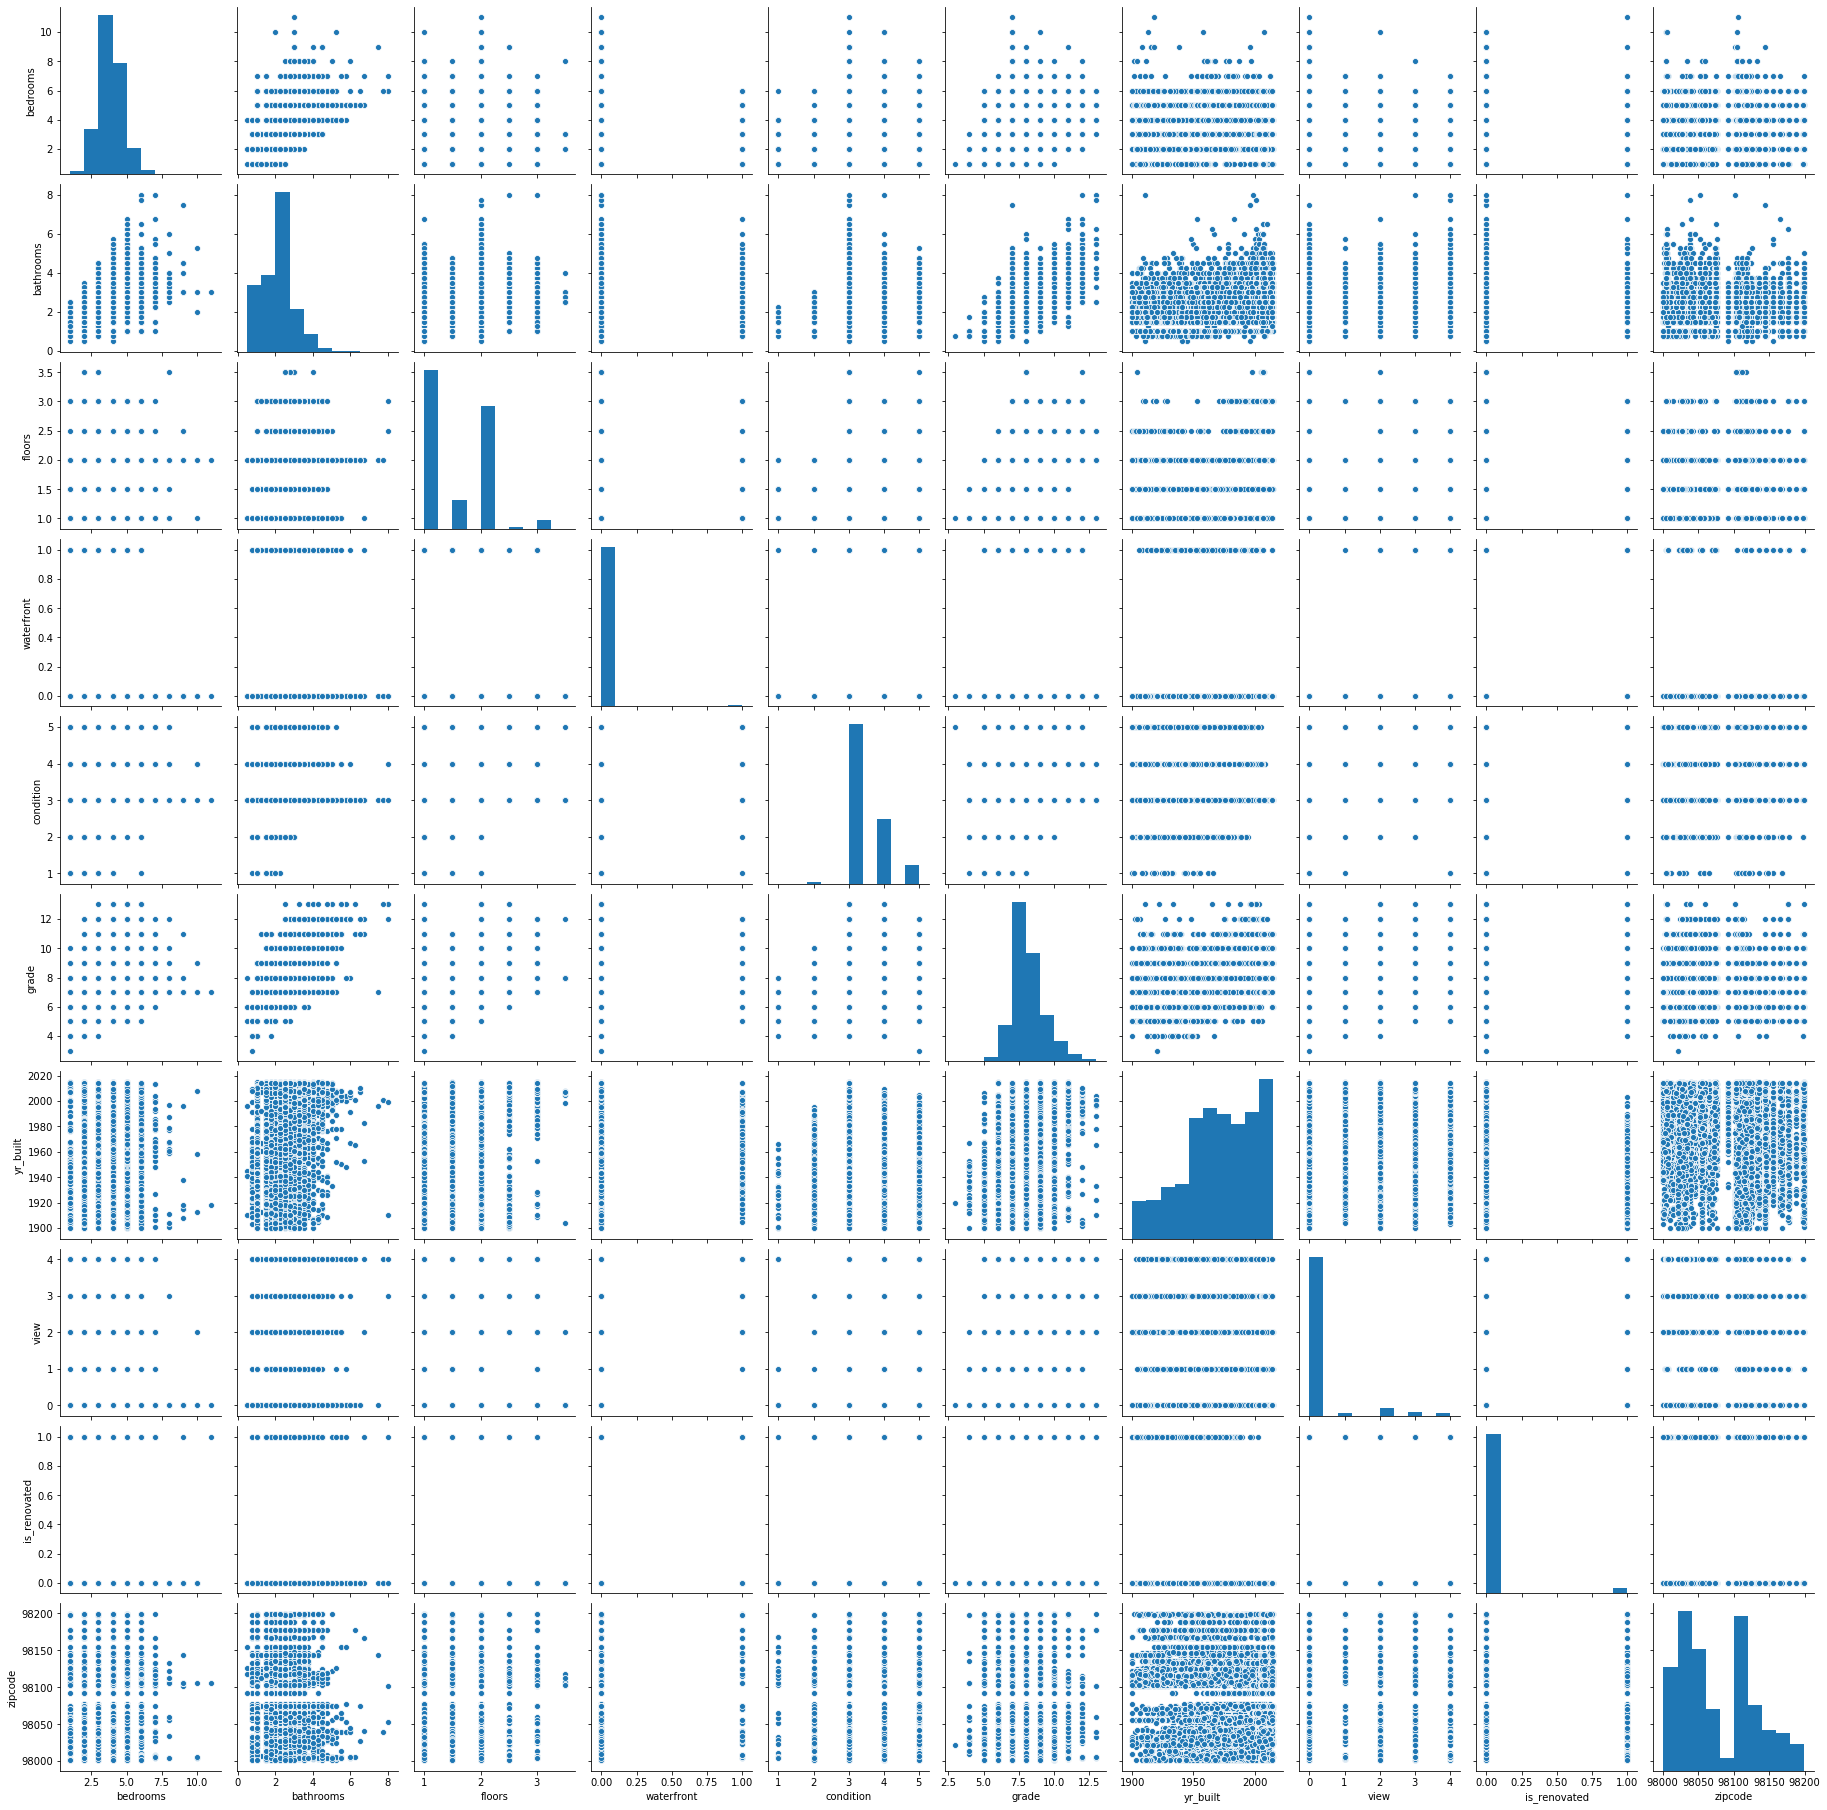

In [10]:
sns.pairplot(data[cat_cols])

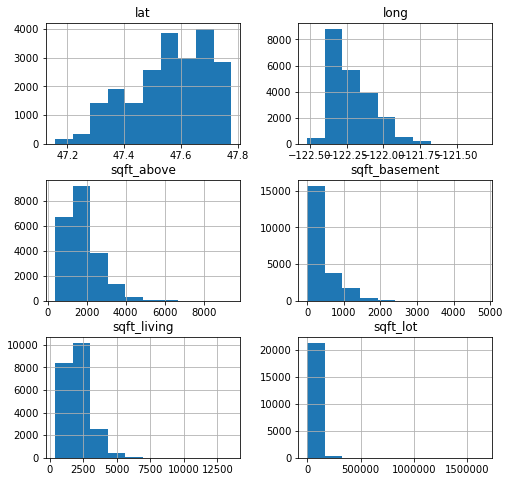

In [38]:
#use a GCA plot to look at histograms of the continuous variables
fig = plt.figure(figsize = (8,8))
ax = fig.gca()
data[con_cols].hist(ax = ax);

None of my continuous variables look normally distributed so I'm going to note that I'll probably need to go back and normalize them. 

(18, 0)

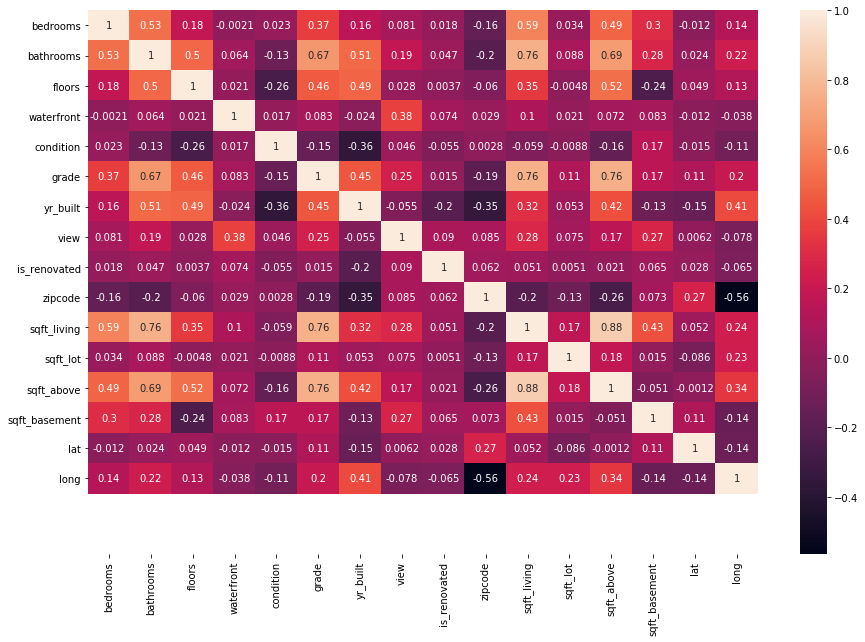

In [12]:
plt.figure(figsize = (15,10))
ax = sns.heatmap(data[cat_cols + con_cols].corr(), annot=True)
ax.set_ylim(18,0)

I can see that some features have high correlations: Bathrooms + sqft, grade & sqft, sqft above and sqft living

I'm going to go ahead and model my data to see what happens. I'll use the scikitlern method, create a train trest split, scale the data, and fit it to a model.

In [41]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression

In [42]:
X = data[x_cols]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=20)

In [44]:
scaler = StandardScaler()
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [45]:
linreg = LinearRegression()
linreg.fit(X_train_scaled, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [46]:
y_hat_train = linreg.predict(X_train_scaled)
y_hat_test = linreg.predict(X_test_scaled)

In [75]:
coefficients = linreg.coef_

In [73]:
X.columns

Index(['floors', 'waterfront', 'condition', 'grade', 'yr_built', 'view',
       'is_renovated', 'zipcode', 'bedrooms', 'bathrooms', 'sqft_living',
       'sqft_lot', 'sqft_above', 'sqft_basement', 'lat', 'long'],
      dtype='object')

In [78]:
coef_dict = dict(list(zip(X.columns, coefficients)))
coef_dict

{'floors': 933.4432752720767,
 'waterfront': 49244.4187629743,
 'condition': 15738.115837854428,
 'grade': 115779.3626075448,
 'yr_built': -79095.91711606717,
 'view': 46018.21082462453,
 'is_renovated': 6843.864994885988,
 'zipcode': -32148.773867338365,
 'bedrooms': -35740.03447334722,
 'bathrooms': 34873.6381546105,
 'sqft_living': 76405.58156830352,
 'sqft_lot': -5810.014819605019,
 'sqft_above': 92686.06424387656,
 'sqft_basement': 33281.244020574806,
 'lat': 84841.89801223546,
 'long': -29951.598295649525}

In [ ]:
# from statsmodels.formula.api import ols
# outcome = 'price'
# x_cols =['floors', 'waterfront', 'condition', 'grade', 'yr_built', 'view', 'is_renovated', 'zipcode', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'sqft_above', 'sqft_basement', 'lat', 'long']
# predictors = '+'.join(x_cols)
# formula = outcome + '~' + predictors
# model = ols(formula=formula, data=data).fit()
# model.summary()

In [82]:
pip install yellowbrick

In [83]:
from yellowbrick.regressor import residuals_plot


ModuleNotFoundError: No module named 'sklearn.metrics._classification'

In [48]:
# train_residuals = y_hat_train - y_train
# test_residuals = y_hat_test - y_test

416     -1.833085e+05
14126   -1.146563e+06
3202    -1.219483e+05
5958    -1.708787e+05
9257     6.484653e+04
             ...     
1607    -6.620942e+04
3915     1.631285e+05
14729    2.334832e+05
4367    -2.834202e+04
15715    8.498791e+04
Name: price, Length: 15117, dtype: float64


In [55]:
from sklearn.metrics import mean_squared_error, r2_score

In [64]:
train_mse = mean_squared_error(y_train, y_hat_train)
test_mse = mean_squared_error(y_test, y_hat_test)
print('Train Mean Squarred Error:', train_mse)
print('Test Mean Squarred Error:', test_mse)

Train Mean Squarred Error: 41399564395.11086
Test Mean Squarred Error: 38634665984.12906


the test error is not worse than the train error, but they're both huge.

In [65]:
from statsmodels.tools.eval_measures import rmse
train_rmse = rmse(y_train, y_hat_train)
test_rmse = rmse(y_test, y_hat_test)
train_rmse, test_rmse

(203468.8290503262, 196557.02985171773)

In [53]:
print(f'train r2: {r2_score(y_train, y_hat_train)}')
print(f'test r2: {r2_score(y_test, y_hat_test)}')

train r2: 0.7005339627471194
test r2: 0.6964788014790179


The R2 score is not terrible but there is a LOT of error. Circling back to the Data Preparation stage, I want to make some transformations on columns that do not fit the assumptions for linear regression. I'll start with log transforming the continuous variables, and then address the multicollinearity.

In [66]:
data_log = pd.DataFrame([])
data_log['loglat'] = np.log(data['lat'])
data_log['loglong'] = np.log(data['long'])
data_log['logsqftabove'] = np.log(data['sqft_above'])
data_log['logsqftbasement'] = np.log(data['sqft_basement'])
data_log['logsqftliving'] = np.log(data['sqft_living'])
data_log['logsqftlot'] = np.log(data['sqft_lot'])

In [69]:
data_log
#try the normalize transform instead

,loglat,loglong,logsqftabove,logsqftbasement,logsqftliving,logsqftlot
0,3.860965,NaN,7.073270,-inf,7.073270,8.639411
1,3.865372,NaN,7.682482,5.991465,7.851661,8.887653
2,3.865726,NaN,6.646391,-inf,6.646391,9.210340
3,3.861168,NaN,6.956545,6.813445,7.580700,8.517193
4,3.863186,NaN,7.426549,-inf,7.426549,8.997147
...,...,...,...,...,...,...
21592,3.864917,NaN,7.333023,-inf,7.333023,7.030857
21593,3.860955,NaN,7.745003,-inf,7.745003,8.667852
21594,3.862715,NaN,6.927558,-inf,6.927558,7.207860
21595,3.861456,NaN,7.377759,-inf,7.377759,7.778211
